In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import xarray
from numba import njit, prange, typed
from tqdm import tqdm

# from run_pangu.utils.util import get_closest_gridbox
from run_pangu.utils import G211
from sklearn.neighbors import BallTree as SKBallTree

idir = Path("/glade/campaign/mmm/parc/schwartz")
tmpdir = Path(os.getenv("TMPDIR"))

In [2]:
g211 = G211.x2()

In [3]:
@njit
def remap(data: np.array, idxs, remapped_values: np.array):  # TODO: what is n for?
    # assume data is 2-D array (pts)
    remapped_values_flat = remapped_values.ravel()
    for i in prange(len(idxs)):
        idx = idxs[i]
        if len(idx) > 0:
            mm = np.max(data[idx])
            remapped_values_flat[i] = mm

In [4]:
idate = pd.to_datetime("20230522")
mems = range(1, 11)
ifiles = []
for mem in mems:
    ifiles.append(
        sorted(
            list(
                idir.glob(
                    f"HWT2023/mpas/{idate:%Y%m%d%H}/post/mem_{mem}/diag.{idate:%Y}-0?-??_??.00.00.nc"
                )
            )
        )
    )
# 1d version
#ifiles = sorted(
#    list(idir.glob(f"HWT2023/mpas/{idate:%Y%m%d%H}/post/mem_*/diag.{idate:%Y}-0?-??_??.00.00.nc"))
#)
len(ifiles)

10

In [5]:
# worked well on casper batch with 32 CPUs (36 possible but took long time in queue)
# and 30G memory
from dask.distributed import Client
if "client" in globals():
    client.close()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/ahijevyc/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/ahijevyc/proxy/8787/status,Workers: 5
Total threads: 10,Total memory: 55.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39041,Workers: 5
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/ahijevyc/proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 55.00 GiB
Comm: tcp://127.0.0.1:38321,Total threads: 2
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/ahijevyc/proxy/34335/status,Memory: 11.00 GiB
Nanny: tcp://127.0.0.1:43441,


In [6]:
np.array(ifiles).shape

(10, 133)

In [7]:
%%time

assert ifiles
print(len(ifiles))
# 3km_mesh/static.nc has ns since Time=0000-01-01, which overflows
grid = xarray.open_dataset(idir / "MPAS/15-3km_mesh/mpas_init/static.nc", decode_times=False)

10
CPU times: user 928 ms, sys: 245 ms, total: 1.17 s
Wall time: 2.04 s


In [8]:
grid

<xarray.Dataset> Size: 10GB
Dimensions:                   (Time: 1, nCells: 6488066, nEdges: 19464192,
                               nVertices: 12976128, TWO: 2, maxEdges: 7,
                               maxEdges2: 14, vertexDegree: 3, R3: 3,
                               nMonths: 12, FIFTEEN: 15, TWENTYONE: 21)
Dimensions without coordinates: Time, nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, R3, nMonths, FIFTEEN,
                                TWENTYONE
Data variables: (12/72)
    xtime                     (Time) |S64 64B ...
    latCell                   (nCells) float32 26MB ...
    lonCell                   (nCells) float32 26MB ...
    xCell                     (nCells) float32 26MB ...
    yCell                     (nCells) float32 26MB ...
    zCell                     (nCells) float32 26MB ...
    ...                        ...
    ol4                       (nCells) float32 26MB ...
    deriv_two                 (nEdges, TWO, FIFTEEN) float32 2GB ...
    advCells                  (nCells, TWENTYONE) int32 545MB ...
    defc_a                    (nCells, maxEdges) float32 182MB ...
    defc_b                    (nCells, maxEdges) float32 182MB ...
    coeffs_reconstruct        (nCells, maxEdges, R3) float32 545MB ...
Attributes: (12/52)
    model_name:                       mpas
    core_name:                        init_atmosphere
    source:                           MPAS
    Conventions:                      MPAS
    git_version:                      v4.0-1355-g9edf494-dirty
    on_a_sphere:                      YES
    ...                               ...
    config_pio_stride:                1
    config_block_decomp_file_prefix:  x5.6488066.cvt.part.
    config_number_of_blocks:          0
    config_explicit_proc_decomp:      NO
    config_proc_decomp_file_prefix:   graph.info.part.
    file_id:                          yw5yulptsy

In [9]:
%%time
var = "refl10cm_max"
ds = xarray.open_mfdataset(
    ifiles,
    combine="nested",
    concat_dim=["mem", "forecastHour"],
    drop_variables=["total_precip_hrly", "tslb", "vorticity_500hPa", "vorticity_700hPa"],
    combine_attrs="drop",
    data_vars=[var],
    compat="override",
    coords="minimal",
    engine="netcdf4",  # netcdf4 faster than h5netcdf
#    join="override",
    parallel=True,
    decode_cf=False,
    decode_coords=False,
).squeeze(dim="Time")
print("assign forecastHour=forecastHour and mem=mem+1")
ds = ds.assign_coords(initialization_time=[idate], forecastHour=ds.forecastHour, mem=ds.mem + 1)
ds

assign forecastHour=forecastHour and mem=mem+1
CPU times: user 15.9 s, sys: 1.38 s, total: 17.3 s
Wall time: 33.7 s


<xarray.Dataset> Size: 37GB
Dimensions:                 (StrLen: 64, nCells: 6488066, forecastHour: 133,
                             mem: 10, initialization_time: 1)
Coordinates:
  * initialization_time     (initialization_time) datetime64[ns] 8B 2023-05-22
  * forecastHour            (forecastHour) int64 1kB 0 1 2 3 ... 129 130 131 132
  * mem                     (mem) int64 80B 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: StrLen, nCells
Data variables: (12/96)
    initial_time            (StrLen) |S1 64B dask.array<chunksize=(64,), meta=np.ndarray>
    xtime                   (StrLen) |S1 64B dask.array<chunksize=(64,), meta=np.ndarray>
    olrtoa                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    rainc                   (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    rainnc                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    refl10cm_max            (forecastHour, mem, nCells) float32 35GB dask.array<chunksize=(1, 1, 926867), meta=np.ndarray>
    ...                      ...
    ushr06                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    vshr06                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    ushr01                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    vshr01                  (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    rainc_hrly              (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>
    rainnc_hrly             (nCells) float32 26MB dask.array<chunksize=(926867,), meta=np.ndarray>

In [10]:
lonCell = (grid.lonCell.values.ravel() + np.pi) % (2 * np.pi) - np.pi
latlon = np.c_[grid.latCell.values.ravel(), lonCell]
X = np.deg2rad(np.c_[g211.lat.ravel(), g211.lon.ravel()])

tree = SKBallTree(latlon, metric="haversine")
rptdist = 40  # km
r = np.deg2rad(rptdist / 111.1)
idxs = tree.query_radius(X, r)
# Convert idxs into a numba-compatible typed list
idxs_list = typed.List(np.array(idx, dtype=np.int64) for idx in idxs)

# Initialize an array to store the remapped values (same shape as the coarse grid)
remapped_values = np.full((ds.sizes["forecastHour"] * ds.sizes["mem"],) + g211.lat.shape, np.nan)

In [11]:
remapped_values.shape

(1330, 129, 185)

In [12]:
[str(d) for d in ds.data_vars if d.startswith("r")]

['rainc',
 'rainnc',
 'refl10cm_max',
 'refl10cm_1km',
 'refl10cm_1km_max',
 'relhum_200hPa',
 'relhum_250hPa',
 'relhum_500hPa',
 'relhum_700hPa',
 'relhum_850hPa',
 'relhum_925hPa',
 'rvort1_max',
 'rainc_hrly',
 'rainnc_hrly']

In [15]:
import multiprocessing as mp

data2d = np.empty(g211.lat.shape)
vars = ["refl10cm_max", "refl10cm_1km", "refl10cm_1km_max", "rvort1_max"]


def upscale(fhr):
    for ifile in tqdm(fhr):
        ofile = tmpdir / str(ifile)[str(ifile).index("schwartz") :]
        os.makedirs(ofile.parent, exist_ok=True)
        ds = xarray.open_dataset(ifile)
        das = []
        for var in vars:
            data1d = ds[var].squeeze().values
            remap(data1d, idxs_list, data2d)
            np.save(
                ofile.with_name(ofile.name.replace("diag.", f"{var}.")).with_suffix(".npy"), data2d
            )
            das.append(data2d.reshape(g211.lat.shape))
        fast = False
        if fast:
            xarray.Dataset(
                {var: (("lat", "lon"), da) for var, da in zip(vars, das)},
                coords={
                    "lat": (("y", "x"), g211.lat),
                    "lon": (("y", "x"), g211.lon),
                },
            ).to_netcdf(ofile.with_suffix(".nc"))


with mp.Pool() as pool:
    for _ in pool.map(upscale, ifiles):
        pass

100%|██████████| 133/133 [01:51<00:00,  1.19it/s]


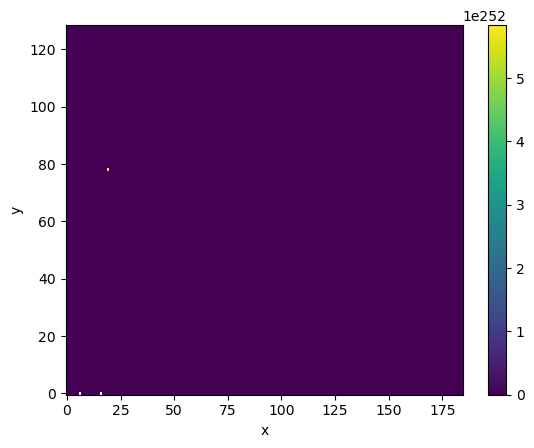

In [16]:
xarray.DataArray(
    data2d.reshape(
        g211.lat.shape
    ),
    coords={
        "lat": (["y", "x"], g211.lat),
        "lon": (["y", "x"], g211.lon),
    },
    dims=["y", "x"],
).plot()

In [ ]:
%%time
remap(
    ds[var].stack(grid2d=ds[var].coords).transpose().values,
    idxs_list,
    remapped_values,
    g211.lat.size,
)

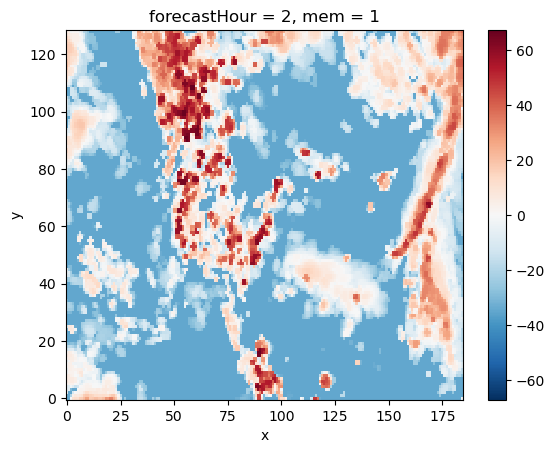

In [21]:
# Convert the remapped values to an xarray DataArray
remapped_da = xarray.DataArray(
    remapped_values.reshape(
        (
            ds.sizes["forecastHour"],
            ds.sizes["mem"],
        )
        + g211.lat.shape
    ),
    coords={
        "forecastHour": ("forecastHour", ds.forecastHour.data),
        "mem": ("mem", ds.mem.data),
        "lat": (["y", "x"], g211.lat),
        "lon": (["y", "x"], g211.lon),
    },
    dims=["forecastHour", "mem", "y", "x"],
)
remapped_da.sel(forecastHour=2, mem=1).plot()

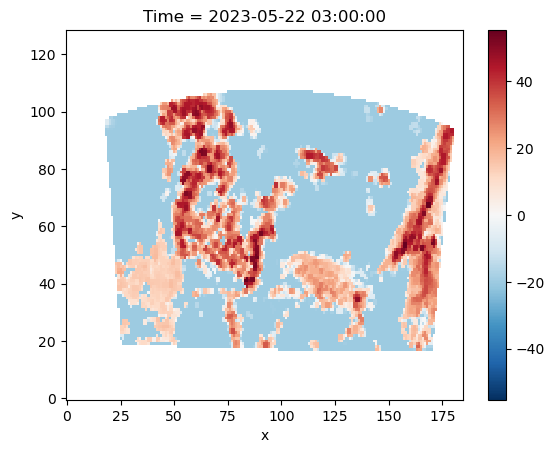

In [11]:
# deterministic forecast with nested grid nest02.tile7 over CONUS
if True:
    # Base data path
    base_path = Path(
        "/glade/campaign/mmm/parc/schwartz/HWT2023/fv3_det/gfdl_2023cSHiELDconfig"
    ) / idate.strftime("%Y%m%d%H")

    # Path to Grid file
    grid_path = base_path / "grid_spec.nest02.tile7.nc"

    # Open the Grid file
    grid_ds = xarray.open_dataset(grid_path)

    latlon = np.deg2rad(np.c_[grid_ds.grid_latt.values.ravel(), grid_ds.grid_lont.values.ravel()])

    tree = SKBallTree(latlon, metric="haversine")
    idxs = tree.query_radius(X, r)

    # Convert idxs into a numba-compatible typed list
    idxs_list = typed.List(np.array(idx, dtype=np.int64) for idx in idxs)
    ds2 = xarray.open_dataset(base_path / "atmos_sos.nest02.tile7.nc")
    remapped_values = np.full((ds2.time.size,) + g211.lat.shape, np.nan)
    # ravel last 2 dims
    remap(ds2["REFC"].values.reshape(ds2.time.size, -1), idxs_list, remapped_values, g211.lat.size)
    # Convert the remapped values to an xarray DataArray
    remapped_da = xarray.DataArray(
        remapped_values,
        coords={
            "Time": ("Time", ds2.time.data),
            "lat": (["y", "x"], g211.lat),
            "lon": (["y", "x"], g211.lon),
        },
        dims=["Time", "y", "x"],
    )
    remapped_da.isel(Time=2).plot()

In [24]:
# ensemble forecast, interpolated to latlon grid over CONUS
ifiles = [
    sorted(
        list(
            (idir / f"HWT2023/fv3/{idate.strftime('%Y%m%d%H')}/post/mem_{mem}").glob(
                "interp_fv3_3km_f[0-9][0-9]0.nc"
            )
        )
    )
    for mem in mems
]

[[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f001.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f002.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f003.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f004.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f005.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f006.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f007.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023052200/post/mem_1/interp_fv3_3km_2023052200_mem1_f008.nc'), PosixPath('/glade/campaign/mmm

In [25]:
%%time
ds2 = xarray.open_mfdataset(ifiles, combine="nested", concat_dim=["mem", "forecastHour"])
ds2 = ds2.squeeze(dim="time").assign_coords(
    initialization_time=[idate], forecastHour=ds2.forecastHour, mem=ds2.mem + 1
)
ds2

CPU times: user 47 s, sys: 2.89 s, total: 49.8 s
Wall time: 1min 18s


<xarray.Dataset> Size: 364GB
Dimensions:              (forecastHour: 204, mem: 3, lat: 1059, lon: 1799,
                          initialization_time: 1)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 8B 2023-05-22
  * forecastHour         (forecastHour) int64 2kB 0 1 2 3 4 ... 200 201 202 203
  * mem                  (mem) int64 24B 1 2 3
Dimensions without coordinates: lat, lon
Data variables: (12/78)
    latitude             (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    longitude            (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    REFC                 (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    CAPEsfc              (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD925              (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD850              (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    ...                   ...
    DPT2m                (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    PRATEsfc             (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    PRATEsfc_accum       (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD10m              (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    VGRD10m              (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    SPFH2m               (forecastHour, mem, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
Attributes:
    initializationTime:  2023052200
    forecastHour:        1
    DX:                  3000.0

In [26]:
latlon = np.deg2rad(np.c_[ds2.latitude.values.ravel(), ds2.longitude.values.ravel()])

In [ ]:
tree = SKBallTree(latlon, metric="haversine")
idxs = tree.query_radius(X, r)

# Convert idxs into a numba-compatible typed list
idxs_list = typed.List(np.array(idx, dtype=np.int64) for idx in idxs)

In [ ]:
remapped_values = np.full((ds2.forecastHour.size * ds2.mem.size,) + g211.lat.shape, np.nan)
# ravel last 2 dims
remap(ds2["REFC"].values.reshape(ds2.time.size, -1), idxs_list, remapped_values, g211.lat.size)

In [ ]:
# Convert the remapped values to an xarray DataArray
remapped_da = xarray.DataArray(
    remapped_values,
    coords={
        "Time": ("Time", ds2.time.data),
        "lat": (["y", "x"], g211.lat),
        "lon": (["y", "x"], g211.lon),
    },
    dims=["Time", "y", "x"],
)
remapped_da.isel(Time=2).plot()